In [1]:
import numpy as np 
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from shutil import copyfile
import keras
from keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, \
    GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, \
    AveragePooling2D, Reshape, Permute, multiply, ZeroPadding2D, Dropout, LeakyReLU
from keras import applications
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
import warnings
from keras.models import Model, Sequential, load_model, model_from_json
from keras import layers
from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from keras.layers import Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D, Reshape
from keras.applications import VGG16 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [2]:
random.seed(34) # For reproductibility
np.random.seed(34)

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First of all, instead of using any of the pre trained model for transfer learning (resnet, inception ..), I choose to find a similar project to this challenge. I find one which is detecting Pneumonia. 
However, I heard about 'attention' in computer vision and I wanted to try to use for this challenge.
The first part is based on the attention with transfer learning (VGG16) / The Second part will use transfer learning but by taking weight of another model that shares some similarity with this one (it was trained to detect pneumonia on XRAY)

# Fast Way Choosing the interpolation resize

The shape of the image is (780, 800, 3)


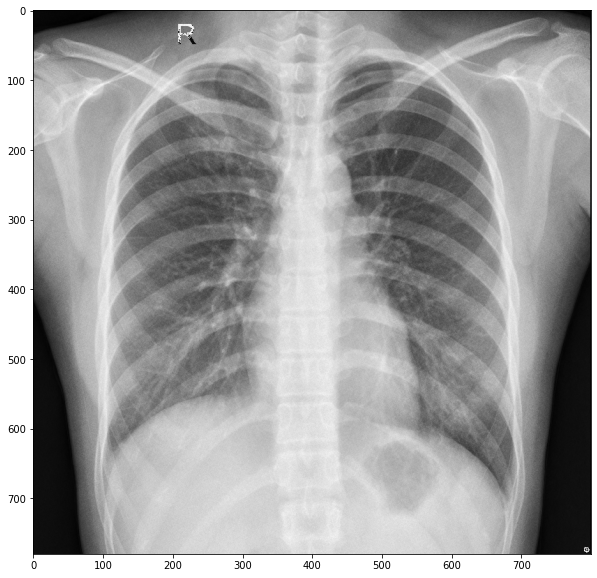

In [4]:
img = cv2.imread('/content/drive/My Drive/tuberculose/data/train/True/ZZVULOBK.png')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(f'The shape of the image is {img.shape}')
plt.figure(figsize=(10,10))
plt.imshow(img)



The shape of the image is (256, 256, 3)


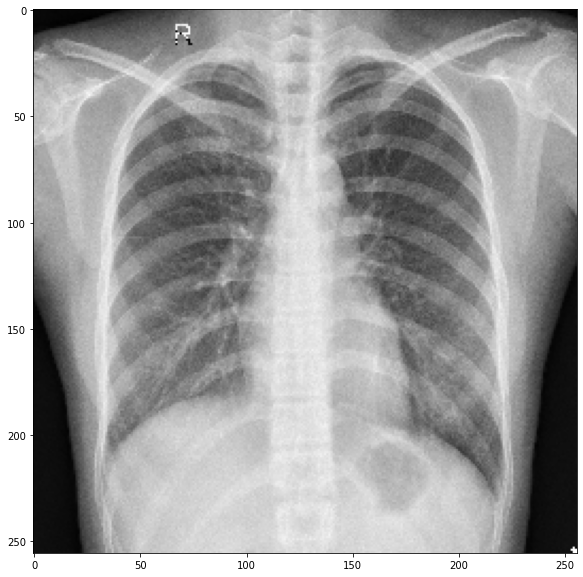

In [5]:
img_resize = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
print(f'The shape of the image is {img_resize.shape}')
plt.figure(figsize=(10,10))
plt.imshow(img_resize)

The shape of the image is (256, 256, 3)


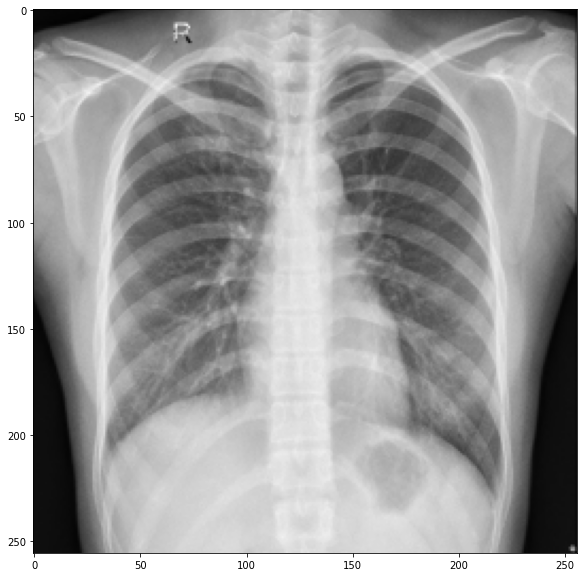

In [6]:
img_resize = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
print(f'The shape of the image is {img_resize.shape}')
plt.figure(figsize=(10,10))
plt.imshow(img_resize)

The shape of the image is (256, 256, 3)


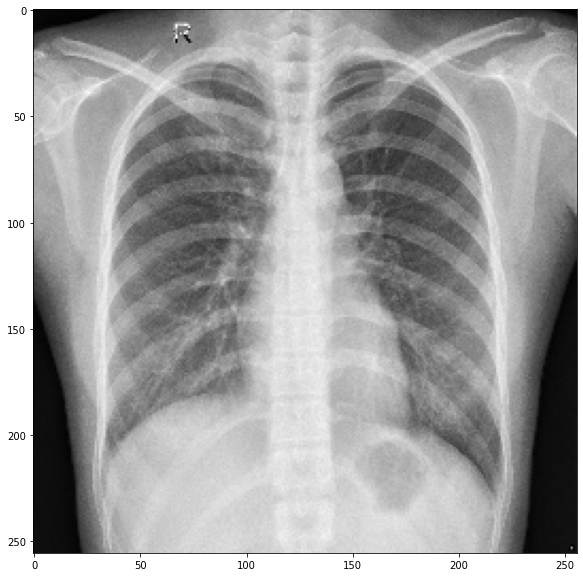

In [7]:
img_resize = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
print(f'The shape of the image is {img_resize.shape}')
plt.figure(figsize=(10,10))
plt.imshow(img_resize)

The resizing with inteprolation = inter_area seems the smoothest one, the other one contains so many noise, I will keep 256*256 (if the training time is too high, I will reduce the dimensionality)

# Generate X / y + X_test 

In [4]:
X_true = []
y_true = []
for image_path in os.listdir("/content/drive/My Drive/tuberculose/data/train/True/"):
  img = cv2.imread("/content/drive/My Drive/tuberculose/data/train/True/" + image_path)
  X_true.append(img)
  y_true.append(1)
X_false = []
y_false = []
for image_path in os.listdir("/content/drive/My Drive/tuberculose/data/train/False/"):
  img = cv2.imread("/content/drive/My Drive/tuberculose/data/train/False/" + image_path)
  X_false.append(img)
  y_false.append(0)
X_test = []
for image_path in os.listdir("/content/drive/My Drive/tuberculose/data/test/"):
  img = cv2.imread("/content/drive/My Drive/tuberculose/data/test/" + image_path)
  X_test.append(img)

X = X_true + X_false
y = y_true + y_false
c = list(zip(X,y))
random.shuffle(c)
X, y = zip(*c)
print(f'{len(X)} images in the train set')
print(f'{len(X_test)} images in the test set')

718 images in the train set
82 images in the test set


In [5]:
# Hot Encode Label
lb = {1 : [0,1], 0 : [1,0]}
y_lb = [lb[t] for t in y]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y_lb, test_size=0.1, random_state=42)
print(f'{len(X_train)} images in the train set')
print(f'{len(X_val)} images in the val set')

646 images in the train set
72 images in the val set


In [7]:
y_train, y_val = np.einsum('kli->lik', np.array([y_train])), np.einsum('kli->lik',np.array([y_val]))

In [8]:
y_train.shape

(646, 2, 1)

In [9]:
def generate_predictions(predictions):
  probs = []
  for x in predictions:
    probs.append(x[1])
  return probs

In [10]:
ID_test = [x.split('.')[0] for x in os.listdir("/content/drive/My Drive/tuberculose/data/test/")]

# VGG16 + Basic Architecture

In [16]:
img_height, img_width = 256, 256
batch_size = 16 

## Going to do also some data augmentation since we don't have many images
train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=50,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.25,
                                       zoom_range=0.1,
                                       channel_shift_range = 20,
                                       horizontal_flip = True ,
                                       vertical_flip = True )
val_datagen = ImageDataGenerator(rescale=1./255)


def resize(img):
  img_ = cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_AREA)
  return img_

X_train_resized = np.array([resize(x) for x in X_train])
X_val_resized = np.array([resize(x) for x in X_val])

train_datagen.fit(X_train_resized, augment=True)
val_datagen.fit(X_val_resized)

In [27]:
base_model = VGG16(input_shape =  (256, 256, 3), 
                              include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(68, activation='relu')(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(2, activation='softmax')(x)

model_base = Model(inputs=base_model.input, outputs=x)

model_base.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [24]:
model_base.compile(loss='categorical_crossentropy',     
              optimizer='adam', 
              metrics=['acc'])

In [25]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/tuberculose/xray_tuberculo_base.h5",
                             monitor="val_acc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

#earlystop = EarlyStopping(monitor = 'val_loss', 
                          #min_delta = 0, 
                          #patience = 6,
                          #verbose = 1,
                          #restore_best_weights = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
# We put our call backs into a callback list
callbacks = [reduceLROnPlat, checkpoint]

epochs = 100
nb_train = 646
nb_val = 72
history = model_base.fit_generator(train_datagen.flow(X_train_resized, y_train, batch_size=batch_size),
                                 steps_per_epoch=nb_train // batch_size,
                                 epochs=epochs,
                                 callbacks=callbacks,
                                 validation_data=val_datagen.flow(X_val_resized, y_val, batch_size=batch_size),
                                 validation_steps=nb_val // batch_size)

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.8651 - acc: 0.5730
Epoch 00001: val_acc improved from -inf to 0.40625, saving model to /content/drive/My Drive/tuberculose/xray_tuberculo_base.h5
40/40 [==============================] - 11s 277ms/step - loss: 0.8651 - acc: 0.5730 - val_loss: 0.8193 - val_acc: 0.4062
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.8032 - acc: 0.5619
Epoch 00002: val_acc did not improve from 0.40625
40/40 [==============================] - 10s 251ms/step - loss: 0.8032 - acc: 0.5619 - val_loss: 0.8399 - val_acc: 0.4062
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.7670 - acc: 0.6048
Epoch 00003: val_acc improved from 0.40625 to 0.70312, saving model to /content/drive/My Drive/tuberculose/xray_tuberculo_base.h5
40/40 [==============================] - 11s 266ms/step - loss: 0.7670 - acc: 0.6048 - val_loss: 0.6029 - val_acc: 0.7031
Epoch 4/100
40/40 [==============================] - ETA:

In [28]:
model_base.load_weights("/content/drive/My Drive/tuberculose/xray_tuberculo_base.h5")
x_test_ = np.array([resize(x) for x in X_test])
gen = ImageDataGenerator(rescale=1./255)
gen.fit(x_test_)
predict = model_base.predict(gen.flow(x_test_, batch_size=1, shuffle=False))
proba = generate_predictions(predict)
sub = pd.DataFrame({'ID' : ID_test, 'LABEL' : proba})
sub.to_csv('/content/drive/My Drive/tuberculose/sub_base.csv', index=False)

The score of this submissions is equal to 0.927601809954751. 

Now let's see if we can improve it

# VGG16 + Attention

## Freeze all

In [139]:
def model_attention(learning_rate = 0.001):
    base_pretrained_model = VGG16(input_shape =  (256, 256, 3), 
                              include_top = False, weights = 'imagenet')
    base_pretrained_model.trainable = False
    model = Sequential()
    pt_features = Input((8, 8, 512) , name = 'feature_input')
    pt_depth = 512
    bn_features = BatchNormalization()(pt_features)
    # here we do an attention mechanism to turn pixels in the GAP on an off
    attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(bn_features)
    attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer) # smooth results
    attn_layer = Conv2D(1, 
                        kernel_size = (1,1), 
                        padding = 'valid', 
                        activation = 'sigmoid')(attn_layer)
    # branch it to all channel
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
                   activation = 'linear', use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)
    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = Dropout(0.5)(gap)
    dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
    out_layer = Dense(2, activation = 'softmax')(dr_steps)
    attn_model = Model(inputs = [pt_features], outputs = [out_layer], name = 'attention_model')

    attn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                               metrics = ['acc'])
    
    print('Summary of Attention model only: ')
    print(attn_model.summary())
    
    

    
    tb_model = Sequential(name = 'combined_model')
    base_pretrained_model.trainable = False
    tb_model.add(base_pretrained_model)
    tb_model.add(attn_model)
    tb_model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy',
                               metrics = ['acc'])
    print("Summary of final model: ")
    print(tb_model.summary())
    
    return tb_model

In [140]:
model = model_attention()

Summary of Attention model only: 
Model: "attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      [(None, 8, 8, 512)]  0                                            
__________________________________________________________________________________________________
batch_normalization_199 (BatchN (None, 8, 8, 512)    2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d_223 (Conv2D)             (None, 8, 8, 128)    65664       batch_normalization_199[0][0]    
__________________________________________________________________________________________________
conv2d_224 (Conv2D)             (None, 8, 8, 32)     4128        conv2d_223[0][0]                 
__________________________________________________

In [134]:
img_height, img_width = 256, 256
batch_size = 16 

## Going to do also some data augmentation since we don't have many images
train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=50,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.25,
                                       zoom_range=0.1,
                                       channel_shift_range = 20,
                                       horizontal_flip = True ,
                                       vertical_flip = True )
val_datagen = ImageDataGenerator(rescale=1./255)


def resize(img):
  img_ = cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_AREA)
  return img_

X_train_resized = np.array([resize(x) for x in X_train])
X_val_resized = np.array([resize(x) for x in X_val])

train_datagen.fit(X_train_resized, augment=True)
val_datagen.fit(X_val_resized)

In [57]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/tuberculose/xray_tuberculo.h5",
                             monitor="val_acc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

#earlystop = EarlyStopping(monitor = 'val_loss', 
                          #min_delta = 0, 
                          #patience = 6,
                          #verbose = 1,
                          #restore_best_weights = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
# We put our call backs into a callback list
callbacks = [reduceLROnPlat, checkpoint]

In [96]:
epochs = 100
nb_train = 646
nb_val = 72
history = model.fit_generator(train_datagen.flow(X_train_resized, y_train, batch_size=batch_size),
                                 steps_per_epoch=nb_train // batch_size,
                                 epochs=epochs,
                                 callbacks=callbacks,
                                 validation_data=val_datagen.flow(X_val_resized, y_val, batch_size=batch_size),
                                 validation_steps=nb_val // batch_size)

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.6407 - acc: 0.6873
Epoch 00001: val_acc improved from -inf to 0.42188, saving model to /content/drive/My Drive/tuberculose/xray_tuberculo.h5
40/40 [==============================] - 11s 282ms/step - loss: 0.6407 - acc: 0.6873 - val_loss: 0.7480 - val_acc: 0.4219
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.5681 - acc: 0.6984
Epoch 00002: val_acc improved from 0.42188 to 0.70312, saving model to /content/drive/My Drive/tuberculose/xray_tuberculo.h5
40/40 [==============================] - 10s 241ms/step - loss: 0.5681 - acc: 0.6984 - val_loss: 0.6060 - val_acc: 0.7031
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.5539 - acc: 0.7048
Epoch 00003: val_acc improved from 0.70312 to 0.76562, saving model to /content/drive/My Drive/tuberculose/xray_tuberculo.h5
40/40 [==============================] - 10s 240ms/step - loss: 0.5539 - acc: 0.7048 - val_loss: 0.5771 - val_acc:

In [103]:
model.load_weights("/content/drive/My Drive/tuberculose/xray_tuberculo.h5")
#x_test_ = np.array([resize(x) for x in X_test])
gen = ImageDataGenerator(rescale=1./255)
gen.fit(x_test_)
predict = model.predict(gen.flow(x_test_, batch_size=1, shuffle=False))

In [115]:
proba = generate_predictions(predict)
sub = pd.DataFrame({'ID' : ID_test, 'LABEL' : proba})
sub.to_csv('/content/drive/My Drive/tuberculose/sub_0.csv', index=False)

Well we got a score of 0.963800 which made us ranked 32 on 100. This score is better than the previous one, which shows that Attention is All I Need (I hope you get the ref)

The best score is 1 , maybe we can try to approach it (but since we only have the small resolution data, it may be hard)

## Unfreeze some parameters

In [ ]:
base_pretrained_model = VGG16(input_shape =  (256, 256, 3), 
                              include_top = False, weights = 'imagenet')

In [ ]:
base_pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

I will unfreeze the  last layer (block5_conv3) (since we have few images)

In [116]:
def model_attention_unfreeze(learning_rate = 0.01):
    base_pretrained_model = VGG16(input_shape =  (256, 256, 3), 
                              include_top = False, weights = 'imagenet')
    for layer in base_pretrained_model.layers[:17]:
      layer.trainable = False
    model = Sequential()
    pt_features = Input((8, 8, 512) , name = 'feature_input')
    pt_depth = 512
    bn_features = BatchNormalization()(pt_features)
    # here we do an attention mechanism to turn pixels in the GAP on an off
    attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(bn_features)
    attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer) # smooth results
    attn_layer = Conv2D(1, 
                        kernel_size = (1,1), 
                        padding = 'valid', 
                        activation = 'sigmoid')(attn_layer)
    # branch it to all channel
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
                   activation = 'linear', use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)
    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = Dropout(0.5)(gap)
    dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
    out_layer = Dense(2, activation = 'softmax')(dr_steps)
    attn_model = Model(inputs = [pt_features], outputs = [out_layer], name = 'attention_model')

    attn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                               metrics = ['acc'])
    
    print('Summary of Attention model only: ')
    print(attn_model.summary())
    
    

    
    tb_model = Sequential(name = 'combined_model')
    for layer in base_pretrained_model.layers[:17]:
      layer.trainable = False
    tb_model.add(base_pretrained_model)
    tb_model.add(attn_model)
    tb_model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy',
                               metrics = ['acc'])
    print("Summary of final model: ")
    print(tb_model.summary())
    
    return tb_model

In [120]:
model_1 = model_attention_unfreeze()

Summary of Attention model only: 
Model: "attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      [(None, 8, 8, 512)]  0                                            
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 8, 8, 512)    2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 8, 8, 128)    65664       batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 8, 8, 32)     4128        conv2d_25[0][0]                  
__________________________________________________

In [119]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/tuberculose/xray_tuberculo_0.h5",
                             monitor="val_acc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

#earlystop = EarlyStopping(monitor = 'val_loss', 
                          #min_delta = 0, 
                          #patience = 6,
                          #verbose = 1,
                          #restore_best_weights = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
# We put our call backs into a callback list
callbacks = [reduceLROnPlat, checkpoint]

epochs = 100
nb_train = 646
nb_val = 72

history = model_1.fit_generator(train_datagen.flow(X_train_resized, y_train, batch_size=batch_size),
                                 steps_per_epoch=nb_train // batch_size,
                                 epochs=epochs,
                                 callbacks=callbacks,
                                 validation_data=val_datagen.flow(X_val_resized, y_val, batch_size=batch_size),
                                 validation_steps=nb_val // batch_size)

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.7479 - acc: 0.6460
Epoch 00001: val_acc improved from -inf to 0.59375, saving model to /content/drive/My Drive/tuberculose/xray_tuberculo_0.h5
40/40 [==============================] - 11s 286ms/step - loss: 0.7479 - acc: 0.6460 - val_loss: 0.9635 - val_acc: 0.5938
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.5959 - acc: 0.7016
Epoch 00002: val_acc improved from 0.59375 to 0.75000, saving model to /content/drive/My Drive/tuberculose/xray_tuberculo_0.h5
40/40 [==============================] - 10s 246ms/step - loss: 0.5959 - acc: 0.7016 - val_loss: 0.5218 - val_acc: 0.7500
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.5698 - acc: 0.7460
Epoch 00003: val_acc did not improve from 0.75000
40/40 [==============================] - 9s 235ms/step - loss: 0.5698 - acc: 0.7460 - val_loss: 0.7542 - val_acc: 0.5625
Epoch 4/100
40/40 [==============================] - ETA: 0s - l

In [121]:
model_1.load_weights("/content/drive/My Drive/tuberculose/xray_tuberculo_0.h5")
#x_test_ = np.array([resize(x) for x in X_test])
gen = ImageDataGenerator(rescale=1./255)
gen.fit(x_test_)
predict = model_1.predict(gen.flow(x_test_, batch_size=1, shuffle=False))
proba = generate_predictions(predict)
sub = pd.DataFrame({'ID' : ID_test, 'LABEL' : proba})
sub.to_csv('/content/drive/My Drive/tuberculose/sub_1.csv', index=False)

Score of 0.9276. I thought that training the last layer of the VGG16 will help us improve the performance. 
VGG16 is not train on medical imaging, I assumed that letting him learn "something new" (by setting the last layer to trainable) will make him "discover" other specific features. Well at least I tried (maybe we can improve the accuracy by resizing image to a bigger size)

# ResNet and Another Attention Architecture

I will keep the resnet model untrainable.

@TODO : Develop another specific attention layer (https://towardsdatascience.com/visual-attention-model-in-deep-learning-708813c2912c .. look for others articles ..)

# High Resolution 
I can see that I can probably use a higher resolution of the image since I have some memory gpu available

In [11]:
img_height, img_width = 500, 500
batch_size = 16 

## Going to do also some data augmentation since we don't have many images
train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=50,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.25,
                                       zoom_range=0.1,
                                       channel_shift_range = 20,
                                       horizontal_flip = True ,
                                       vertical_flip = True )
val_datagen = ImageDataGenerator(rescale=1./255)


def resize(img):
  img_ = cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_AREA)
  return img_

X_train_resized = np.array([resize(x) for x in X_train])
X_val_resized = np.array([resize(x) for x in X_val])

train_datagen.fit(X_train_resized, augment=True)
val_datagen.fit(X_val_resized)

In [14]:
def model_attention(learning_rate = 0.001):
    base_pretrained_model = VGG16(input_shape =  (500, 500, 3), 
                              include_top = False, weights = 'imagenet')
    base_pretrained_model.trainable = False
    model = Sequential()
    pt_features = Input((15, 15, 512) , name = 'feature_input')
    pt_depth = 512
    bn_features = BatchNormalization()(pt_features)
    # here we do an attention mechanism to turn pixels in the GAP on an off
    attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(bn_features)
    attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer) # smooth results
    attn_layer = Conv2D(1, 
                        kernel_size = (1,1), 
                        padding = 'valid', 
                        activation = 'sigmoid')(attn_layer)
    # branch it to all channel
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
                   activation = 'linear', use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)
    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = Dropout(0.5)(gap)
    dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
    out_layer = Dense(2, activation = 'softmax')(dr_steps)
    attn_model = Model(inputs = [pt_features], outputs = [out_layer], name = 'attention_model')

    attn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                               metrics = ['acc'])
    
    print('Summary of Attention model only: ')
    print(attn_model.summary())
    
    

    
    tb_model = Sequential(name = 'combined_model')
    base_pretrained_model.trainable = False
    tb_model.add(base_pretrained_model)
    tb_model.add(attn_model)
    tb_model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy',
                               metrics = ['acc'])
    print("Summary of final model: ")
    print(tb_model.summary())
    
    return tb_model
model_high = model_attention()

Summary of Attention model only: 
Model: "attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      [(None, 15, 15, 512) 0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 15, 15, 512)  2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 15, 15, 128)  65664       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 15, 15, 32)   4128        conv2d_5[0][0]                   
__________________________________________________

In [13]:
model_high.compile(loss='categorical_crossentropy',     
              optimizer='adam', 
              metrics=['acc'])

checkpoint = ModelCheckpoint("/content/drive/My Drive/tuberculose/xray_tuberculo_high.h5",
                             monitor="val_acc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

#earlystop = EarlyStopping(monitor = 'val_loss', 
                          #min_delta = 0, 
                          #patience = 6,
                          #verbose = 1,
                          #restore_best_weights = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
# We put our call backs into a callback list
callbacks = [reduceLROnPlat, checkpoint]

epochs = 80
nb_train = 646
nb_val = 72
batch_size = 16
history = model_high.fit_generator(train_datagen.flow(X_train_resized, y_train, batch_size=batch_size),
                                 steps_per_epoch=nb_train // batch_size,
                                 epochs=epochs,
                                 callbacks=callbacks,
                                 validation_data=val_datagen.flow(X_val_resized, y_val, batch_size=batch_size),
                                 validation_steps=nb_val // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
40/40 [==============================] - ETA: 0s - loss: 0.6267 - acc: 0.6587
Epoch 00001: val_acc improved from -inf to 0.60938, saving model to /content/drive/My Drive/tuberculose/xray_tuberculo_high.h5
40/40 [==============================] - 38s 940ms/step - loss: 0.6267 - acc: 0.6587 - val_loss: 0.6205 - val_acc: 0.6094
Epoch 2/80
40/40 [==============================] - ETA: 0s - loss: 0.5693 - acc: 0.6952
Epoch 00002: val_acc improved from 0.60938 to 0.70312, saving model to /content/drive/My Drive/tuberculose/xray_tuberculo_high.h5
40/40 [==============================] - 38s 949ms/step - loss: 0.5693 - acc: 0.6952 - val_loss: 0.6335 - val_acc: 0.7031
Epoch 3/80
40/40 [==============================] - ETA: 0s - loss: 0.5690 - acc: 0.7048
Epoch 00003: val_acc improved from 0.70312 to 0.71875, saving model to /content/drive/My Drive/tuberculose/xray_tuberculo_high.h5
40/40 [===================

In [16]:
model_high.load_weights("/content/drive/My Drive/tuberculose/xray_tuberculo_high.h5")
x_test_ = np.array([resize(x) for x in X_test])
gen = ImageDataGenerator(rescale=1./255)
gen.fit(x_test_)
predict = model_high.predict(gen.flow(x_test_, batch_size=1, shuffle=False))
proba = generate_predictions(predict)
sub = pd.DataFrame({'ID' : ID_test, 'LABEL' : proba})
sub.to_csv('/content/drive/My Drive/tuberculose/sub_high_res.csv', index=False)

Score 0.9638 , same as before.